# **Sentiment Analysis and Visualization of Messi-Related Conversations**

## **Understanding Public Sentiment**

This notebook continues the exploration of public conversations about Lionel Messi after Argentina's 2018 FIFA World Cup performance. Building upon the insights gained from word frequency analysis and topic modeling, this step dives into the sentiment dimension of the data. The primary goal is to assess the balance between positive and negative sentiment in the conversations, uncovering whether a polarization ("grieta") exists.

### **Key Objectives**
1. **Vectorizing Text Data with Word2Vec**:
   - Use Word2Vec to represent words in a dense vector space, capturing semantic relationships and contextual similarities.
   - Train Word2Vec on the dataset to tailor embeddings to the specific language and tone used in Messi-related conversations.

2. **Clustering and Visualization with t-SNE**:
   - Apply t-SNE (t-Distributed Stochastic Neighbor Embedding) to reduce the dimensionality of the Word2Vec embeddings.
   - Visualize the semantic space of words to identify clusters of positive and negative sentiment.
   - Explore how sentiment-laden words relate to broader conversational themes.

3. **Sentiment Analysis**:
   - Map clusters and key terms to sentiment scores (positive, negative, neutral).
   - Analyze the distribution of sentiment to determine whether conversations are balanced or skewed toward specific opinions.

### **Why This Notebook Is Important**
This notebook is pivotal in answering the project's key questions about societal polarization. By linking semantic relationships and sentiment scores, it helps identify whether positive and negative sentiment dominate separate clusters, providing evidence for or against the hypothesis of a divided public opinion.

Through advanced NLP techniques and visualization, this notebook translates textual data into actionable insights that bring us closer to understanding the public's perception of Lionel Messi.

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from gensim import corpora, models, similarities, matutils
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors
from gensim.matutils import cossim
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
from nltk.stem import SnowballStemmer

In [86]:
df = pd.read_csv('../data/processed/messi_comments_cleaned.csv', skipinitialspace=True)
messi_analisis = df[df['text'].notnull()]

In [87]:
messi_analisis.head()

,_id,_index,_score,_type,page_name,raw_text,text,type,detected_language,lowercased_text,text_no_urls,text_no_special_chars,text_no_stopwords,stemmed_text
2,1.800000e+16,social__instagram__messi,1,doc,messicirque,Consider coming to Chicago plz 🙏🏻,consider coming to chicago plz,instagram_comment,en,NaN,NaN,NaN,NaN,NaN
3,1.790000e+16,social__instagram__messi,1,doc,messicirque,@calcagnoc @mariolymonge,@calcagnoc @mariolymonge,instagram_comment,it,NaN,NaN,NaN,NaN,NaN
4,1.790000e+16,social__instagram__messi,1,doc,messicirque,@icriango92 daleeeeeee,@icriango92 daleeeeeee,instagram_comment,nl,NaN,NaN,NaN,NaN,NaN
5,1.790000e+16,social__instagram__messi,1,doc,messicirque,@uelinton_lima #messicirque,@uelinton_lima #messicirque,instagram_comment,it,NaN,NaN,NaN,NaN,NaN
6,1.800000e+16,social__instagram__messi,1,doc,messicirque,King of Kings @leomessi 👑,king of kings @leomessi,instagram_comment,en,NaN,NaN,NaN,NaN,NaN


In [88]:
messi_analisis_dict = messi_analisis.to_dict()
print(messi_analisis_dict.keys())

dict_keys(['_id', '_index', '_score', '_type', 'page_name', 'raw_text', 'text', 'type', 'detected_language', 'lowercased_text', 'text_no_urls', 'text_no_special_chars', 'text_no_stopwords', 'stemmed_text'])


In [89]:
#Make a list of comments
comments = []
for hit in messi_analisis_dict['text']:
    comments.append(''.join(messi_analisis_dict['text'][hit]))

In [90]:
print(comments[:5])

['consider coming to chicago plz ', '@calcagnoc @mariolymonge', '@icriango92 daleeeeeee', '@uelinton_lima #messicirque', 'king of kings @leomessi ']


In [91]:
#We need to make some further cleraning to the corpus
# Define the cleaning function
def clean_comment(comment):
    comment = re.sub(r"@\w+", " ", comment)  # Remove handles
    comment = re.sub(r"#\w+", " ", comment)  # Remove hashtags
    comment = re.sub(r"[^\w\s]", " ", comment)  # Remove punctuation
    comment = re.sub(r'\s+', ' ', comment).strip()  # Remove extra spaces and line breaks
    return comment

In [92]:
# Apply the cleaning function to each comment
cleaned_corpus = [clean_comment(comment) for comment in comments]
cleaned_corpus = [comment for comment in cleaned_corpus if comment]

In [93]:
cleaned_corpus[:5]  

['consider coming to chicago plz',
 'daleeeeeee',
 'king of kings',
 'gran capi',
 'ola mesis si quiero ganar una entrada para yo verte en persona por que yo sol tu fan']

In [94]:
replacements = {
    'StandWithKerala': '',
    'https://youtu.be/i': '',
    'http://www.wasap.my': '',
    'https://a.cstmapp.com': '',
    '?': '',
    '!': '',
    'mesi': 'messi',
    'messii': 'messi',
    'idolooooooo': 'idolo',
    'youuuuuu': 'you',
    'kiiing': 'king',
    'lovee': 'love',
    'youuuuuuu': 'you',
    'hermosooo': 'hermoso',
    'uuuuu': 'u',
    'daleeeeeee': 'dale',
    'mannn': 'man',
    'lindooooo': 'lindo',
    'wachoooo': 'guacho',
    'lave': 'love',
    'kkkkkkkkkkkkkkkk': 'king',
    'kinggggg': 'king',
    'grandeeeeeee': 'grande',
    'craaaack': 'crack',
    'vamoossssss': 'vamos',
    'vamps': 'vamos',
    'tuyaaa': 'tuya',
    'podesss': 'podes',
    'puedeeee': 'puede',
    'vamooss': 'vamos',
    'vamoos': 'vamos',
    'papaaaa': 'papa',
    'campeonnnn': 'campeon',
    'neneeee': 'nene',
    'fuerzasss': 'fuerza',
    'fuerzaaa': 'fuerza',
    'argentinaaa': 'argentina',
    'leeooo': 'leo',
    'vamooooo': 'vamos',
    'genioooooooooo': 'genio',
    'vamosss': 'vamos',
    'vamod': 'vamos',
    'suerteeee': 'suerte',
    'dioss': 'dios',
    'kiiiiing': 'king',
    'messsssi': 'messi',
    'bancoo': 'banco',
    'locoooo': 'loco',
    'ting': 'king',
    'messiiiiiiiiii': 'messi',
    'messiiiiiiii': 'messi',
    'messsiiiiii': 'messi',
    'messsiiii': 'messi',
    'messiiii': 'messi',
    'argntina': 'argentina',
    'agentina': 'argentina',
    'argentinaaaaaaa': 'argentina',
    'oof': '',
    'ly': '',
    'kkkkkkkkkkkkk': 'king'
}

In [95]:
# Apply the replacements
def apply_replacements(text, replacements):
    for old, new in replacements.items():
        text = text.replace(old, new)
    return text

cleaned_corpus = [apply_replacements(comment, replacements) for comment in cleaned_corpus]

In [96]:
cleaned_corpus[:5]

['consider coming to chicago plz',
 'dale',
 'king of kings',
 'gran capi',
 'ola messis si quiero ganar una entrada para yo verte en persona por que yo sol tu fan']

In [97]:
# tiro los tokens no alphabeticos 
trainset = []
for sent in tqdm(cleaned_corpus):
    tokens = []#corpus
    for token in word_tokenize(sent):
        if token.isalpha():
            tokens.append(token)
    trainset.append(tokens)

100%|██████████| 251000/251000 [00:12<00:00, 19399.71it/s]


In [98]:
print("The corpus has", len(trainset), "sentences and", sum([len(x) for x in trainset]), "words")

The corpus has 251000 sentences and 2043384 words


In [99]:
# "window" is the size of the window. window = 10 means using 10 words to the left and 10 words to the right
# "n_dim" is the dimension (i.e., the length) of the word2vec vectors
# "workers" is the number of cores used in parallel. To take advantage of this, you need to have Cython installed
# "sample": word2vec filters words that appear more frequently than "sample"
# "min_count": word2vec filters words with fewer occurrences than "min_count"
# "sg": to run the Skip-gram model (sg = 1), to run the CBOW model (sg = 0)
# For more details, see: https://radimrehurek.com/gensim/models/word2vec.html
n_dim = 20
w2v_model = Word2Vec(trainset, workers=4, vector_size=n_dim, min_count=10, window=7, sample=1e-2, negative=10, sg=1)

In [100]:
#Save the model to the results folder
results_dir = '../results'
os.makedirs(results_dir, exist_ok=True)

model_path = os.path.join(results_dir, 'messi_2dim')

w2v_model.save(model_path)

print(f'Model saved to {model_path}')

Model saved to ../results/messi_2dim


In [101]:
#w2v_model = Word2Vec.load("../results/messi_2dim")  # load model ww

In [102]:
w2v_model.wv["messi"]  #vector representation of the word "messi"

array([-0.27646434, -0.06292904,  0.7249249 ,  1.0098152 , -0.09983145,
       -0.3751656 , -0.00356581, -0.10369779, -0.9766303 ,  0.47543597,
       -0.57478255,  0.25247318,  0.32908008,  0.01537866,  0.16504428,
        0.40081185,  0.7049747 , -0.38098848,  0.25159523, -0.7712678 ],
      dtype=float32)

In [103]:
# Lets see the most similar words to "messi"
w2v_model.wv.most_similar(positive=["messi"], negative=[], topn=15)

[('lionel', 0.8904860019683838),
 ('messy', 0.879732072353363),
 ('leomessi', 0.8782386183738708),
 ('leo', 0.8702042698860168),
 ('argentina', 0.8584555387496948),
 ('leooooo', 0.8580862879753113),
 ('messii', 0.8546197414398193),
 ('messiii', 0.8496592044830322),
 ('papi', 0.8484838604927063),
 ('mann', 0.844642698764801),
 ('massi', 0.8351081013679504),
 ('goat', 0.8314341306686401),
 ('leoo', 0.8301492929458618),
 ('leoooo', 0.8288233876228333),
 ('leonel', 0.8279175758361816)]

In [104]:
w2v_model.wv.most_similar(positive=["seleccion"], negative=[], topn=15)

[('traidor', 0.9351709485054016),
 ('redonda', 0.9350624084472656),
 ('dejamos', 0.9304874539375305),
 ('volvete', 0.9238334894180298),
 ('usando', 0.9228062033653259),
 ('clove', 0.9223501682281494),
 ('albiceleste', 0.9219019412994385),
 ('lleves', 0.9218097925186157),
 ('infeliz', 0.9195303916931152),
 ('rompen', 0.9185332655906677),
 ('sele', 0.9182926416397095),
 ('hinchada', 0.9179902076721191),
 ('dependemos', 0.9172705411911011),
 ('llevamos', 0.9167706966400146),
 ('renunciar', 0.9165091514587402)]

In [105]:
w2v_model.wv.most_similar(positive=["sampaoli"], negative=[], topn=15) # Va

[('caballero', 0.9342872500419617),
 ('dt', 0.8769216537475586),
 ('jajajajaj', 0.8557303547859192),
 ('pavon', 0.8519107103347778),
 ('jajajaja', 0.8506445288658142),
 ('sirves', 0.8502002358436584),
 ('arquero', 0.8467928171157837),
 ('director', 0.8385975956916809),
 ('higuain', 0.8382443189620972),
 ('romero', 0.8325904011726379),
 ('rakitic', 0.831013023853302),
 ('meza', 0.8305657505989075),
 ('dybala', 0.8278264403343201),
 ('iniesta', 0.8259186148643494),
 ('error', 0.8202085494995117)]

In [106]:
w2v_model.most_similar(positive=["pechofrio"], negative=[], topn=15)

AttributeError: 'Word2Vec' object has no attribute 'most_similar'

In [63]:
w2v_model.wv.most_similar(positive=["argentina"], negative=[], topn=15)

[('argetina', 0.9306855201721191),
 ('arg', 0.8755513429641724),
 ('argentinaa', 0.8697168827056885),
 ('argentinaaaa', 0.8625209927558899),
 ('argentinaaa', 0.8476192355155945),
 ('arjentina', 0.846302330493927),
 ('messi', 0.8437033891677856),
 ('final', 0.8330454230308533),
 ('russia', 0.8265551328659058),
 ('carajooo', 0.8216570615768433),
 ('tango', 0.8192093372344971),
 ('argentinaaaaa', 0.8182703256607056),
 ('leoooo', 0.8163160085678101),
 ('nigeria', 0.815504252910614),
 ('messiiii', 0.8151804804801941)]

In [64]:
w2v_model.wv.most_similar(positive=["mundial", "proximo"], negative=[], topn=15)

[('tuyooo', 0.9384162425994873),
 ('ano', 0.9330341815948486),
 ('campeonato', 0.9308337569236755),
 ('mundia', 0.9286778569221497),
 ('tullo', 0.9280920028686523),
 ('ganara', 0.9193358421325684),
 ('regalanos', 0.9184876084327698),
 ('ganaras', 0.9175201654434204),
 ('premio', 0.9070297479629517),
 ('prox', 0.9046111702919006),
 ('echale', 0.9039946794509888),
 ('igualmente', 0.9036569595336914),
 ('acabado', 0.9002811908721924),
 ('cono', 0.8993327617645264),
 ('demuestre', 0.8963626623153687)]

In [65]:
w2v_model.wv.most_similar(positive=["malo"], negative=[], topn=15)

[('ql', 0.9395216703414917),
 ('qlo', 0.9247188568115234),
 ('perdiste', 0.9136252999305725),
 ('jajaja', 0.9047861695289612),
 ('jajajaja', 0.9045977592468262),
 ('wn', 0.9009936451911926),
 ('tonto', 0.8976081013679504),
 ('pecho', 0.897061288356781),
 ('ctm', 0.896489143371582),
 ('amargo', 0.8936675190925598),
 ('frio', 0.8885468244552612),
 ('erras', 0.886950671672821),
 ('quedaste', 0.8853290677070618),
 ('pinche', 0.8824436664581299),
 ('jajajajaja', 0.8782485127449036)]

## Dimensionality Reduction and Visualization

In this section, we apply dimensionality reduction techniques, to transform high-dimensional word embeddings (e.g., Word2Vec vectors) into a lower-dimensional space. This allows us to visualize the relationships between words, uncover semantic clusters, and identify patterns within the data.

In [66]:
haters = ["pechofrio","overrated","fuck","basura","boludo","amargo", "pessi", 'losser', 'midget', 'fool'] # 10palabras Haters
lovers = ["mejor","vamos","loco","podes","aguante","king","goat",'legend', 'tank', 'banco'] #10 palabras Lovers
neutras = ["argentina","barcelona","barca","club","suarez", "sampaoli", "seleccion", "fifa", "mundial", "cup"] #10 palabras temáticas
target = ["messi"]
palabras = haters + lovers + neutras + target
colores = ["red"]*len(haters)+["green"]*len(lovers)+["blue"]*len(neutras)+["black"]*len(target)

In [ ]:
# Armo una matriz de distancias
distancias=np.zeros((len(palabras),len(palabras))) #matriz cuadrada
for i,ti in enumerate(palabras):
    for j,tj in enumerate(palabras):
        distancias[i,j] = abs(1-w2v_model.wv.similarity(ti,tj))
print (distancias.shape)

(31, 31)


## What is MDS?

**Multidimensional Scaling (MDS)** is a dimensionality reduction technique used to represent high-dimensional data in a lower-dimensional space, while preserving the pairwise distances between data points as accurately as possible. In the context of this study, MDS is applied to Word2Vec embeddings to visualize the semantic relationships between words in public conversations about Lionel Messi, the national team, and the 2018 FIFA World Cup. By reducing the dimensionality, MDS helps identify clusters of positive, negative, or neutral sentiment and uncover patterns in how fans discuss these topics.

In [107]:
# Reduccion de la dimensionalidad y visualizacion 
from sklearn.manifold import MDS

def visualize_embeddings(distancias, palabras, colores):
    plt.figure(figsize=(15,10))
    
    # Dimensionality reduction and visualization using MDS
    mds = MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=123,
              dissimilarity="precomputed", n_jobs=4)
    Y = mds.fit(distancias).embedding_
    
    plt.scatter(Y[:, 0], Y[:, 1], color="black", s=3)
    for label, x, y, color in zip(palabras, Y[:, 0], Y[:, 1], colores):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), color=color, textcoords='offset points', size=10)
    plt.title("MDS")
    plt.show()

    # Define the path to save the plot
    plot_path = os.path.join(results_dir, 'words_sentiment_visual.png')
    plt.savefig(plot_path, format='png')
    print(f'Wordcloud saved to {plot_path}')

/Users/camilojaureguiberry/anaconda3/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


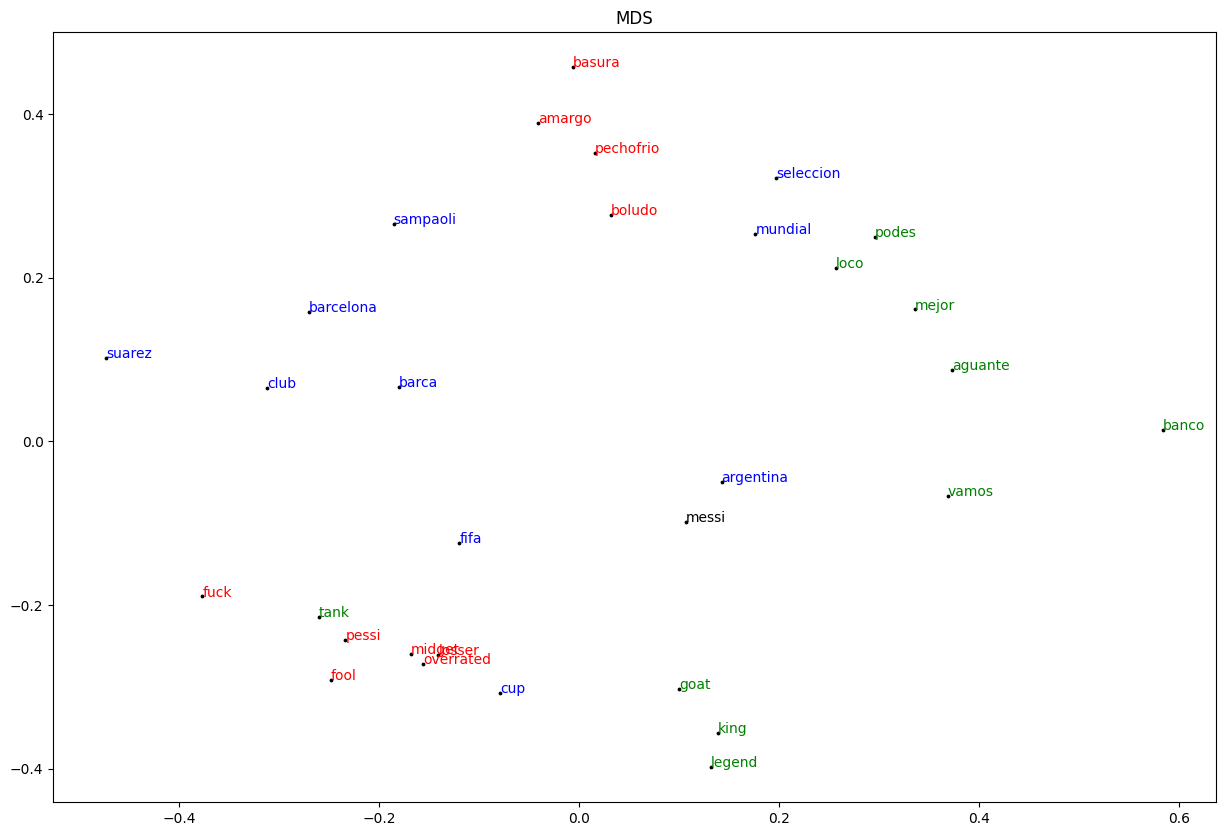

Wordcloud saved to ../results/words_sentiment_visual.png


<Figure size 640x480 with 0 Axes>

In [108]:
visualize_embeddings(distancias,palabras,colores)

In [84]:
q_haters = messi_analisis["_id"][messi_analisis['text'].str.contains("pechofrio|overrated|fuck|basura|boludo|amargo|pessi|losser|midget|fool", regex = True)].count()
print ("Las palabras negativas 'Haters' están en {} comentarios".format(q_haters))

q_lovers = messi_analisis["_id"][messi_analisis['text'].str.contains("mejor|vamos|loco|podes|aguante|king|goat|legend|tank|banco", regex = True)].count()
print ("Las palabras positivas 'lovers' están en {} comentarios".format(q_lovers))

q_neutras = messi_analisis["_id"][messi_analisis['text'].str.contains("argentina|barcelona|barca|club|suarez|sampaoli|seleccion|fifa|mundial|cup", regex = True)].count()
print ("Las palabras neutrales están en {} comentarios".format(q_neutras))


Las palabras negativas 'Haters' están en 1777 comentarios
Las palabras positivas 'lovers' están en 54360 comentarios
Las palabras neutrales están en 25696 comentarios


## Summary Conclusion

The analysis of public conversations about Lionel Messi following the 2018 FIFA World Cup reveals a clear polarization in sentiment. Distinct clusters of **negative** (e.g., "pechofrío," "overrated") and **positive** (e.g., "goat," "legend") words highlight the divided opinions surrounding Messi's performance and persona. 

When quantifying the frequency of these expressions, **positive words ("lovers")** appear in 54,360 comments, significantly outnumbering the 1,777 comments containing **negative words ("haters")**. Additionally, 25,696 comments include **neutral terms** related to Argentina, the team, or other players. 

This demonstrates that while there is criticism and polarization, the overall sentiment in Messi's conversations leans heavily toward admiration and support.